# Nationwide Application Assessment for Computational Telematics
# Jason Barkeloo

Now let's import necessary libraries. <br>
numpy for various linear algebra libraries<br>
pandas for convenient file reading as well as dataframe structures that are convenient to work with<br>
matplotlib for various basic plots<br>
geopy for geodesic distances used for calculations in part 1
sklearn, keras, xgboost (using locally installed tensorflow) for neural network/BDT applications

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from geopy.distance import geodesic
import sys
import sklearn
import keras
from sklearn.model_selection import train_test_split
from keras.models import Model,Sequential
from keras.layers import Dense, Dropout, Input
from keras.callbacks import EarlyStopping
from sklearn.metrics import roc_curve,roc_auc_score
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix
import xgboost as xgb

# Part 1: GPS Data
## (1) What steps did you take to clean the data?
To clean the data let's start by looking at it to see any abnormalities

In [3]:
sample_trips = pd.read_csv("C:/Users/JTBar/Documents/Telematics Exercise Files/sample_trips.csv")

This dataset 'sample_trips.csv' contains 9687 rows of data and 4 columns containing the information on 16 different trips (trip_nb), the local date time (local_dtm), latitude and longitudinal coordinates.  I'm reading it into a pandas dataframe for ease of use.

For the most part the change from one row of local_dtm to the next suggest a rate of 1Hz data collection, however ##many times## this data has a longer sampling rate.  

In [4]:
sample_trips

,trip_nb,local_dtm,latitude,longitude
0,1,19MAY17:07:33:59,40.037952,-83.071342
1,1,19MAY17:07:34:01,40.038181,-83.071274
2,1,19MAY17:07:34:02,40.038349,-83.071304
3,1,19MAY17:07:34:03,40.038448,-83.071266
4,1,19MAY17:07:34:04,40.038551,-83.071236
...,...,...,...,...
9682,16,23MAY17:19:58:05,40.029373,-83.095665
9683,16,23MAY17:19:58:07,40.029633,-83.095161
9684,16,23MAY17:19:58:08,40.029678,-83.095093
9685,16,23MAY17:19:58:09,40.029701,-83.094910


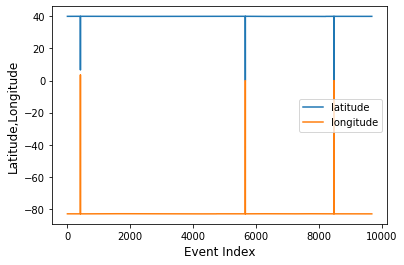

In [43]:
sample_trips.latitude.plot(legend=True)
ax=sample_trips.longitude.plot(legend=True)

ax.set_xlabel('Event Index', fontsize='large')
ax.set_ylabel('Latitude,Longitude', fontsize='large')
plt.legend(loc='best')


In [6]:
sample_trips[410:416].latitude, sample_trips[410:416].longitude

(410    40.064465
 411     6.620114
 412     6.620117
 413     6.620116
 414     6.620114
 415    40.064507
 Name: latitude, dtype: float64,
 410   -83.078590
 411     3.587174
 412     3.587173
 413     3.587172
 414     3.587175
 415   -83.079872
 Name: longitude, dtype: float64)

In [7]:
sample_trips[5660:5665].latitude, sample_trips[5660:5665].longitude

(5660    40.063885
 5661     0.000000
 5662     0.000000
 5663    40.063862
 5664    40.063858
 Name: latitude, dtype: float64,
 5660   -83.064537
 5661     0.000000
 5662     0.000000
 5663   -83.064003
 5664   -83.063843
 Name: longitude, dtype: float64)

In [8]:
sample_trips[8480:8485].latitude, sample_trips[8480:8485].longitude

(8480    40.039795
 8481    40.039890
 8482     0.000000
 8483     0.000000
 8484    40.040298
 Name: latitude, dtype: float64,
 8480   -83.071190
 8481   -83.071175
 8482     0.000000
 8483     0.000000
 8484   -83.071129
 Name: longitude, dtype: float64)

## Cleaning data
Here the latitude and longitude cleaning is done.  The latitude cleaning is done first and should pick up all of the misplaced points as both gps coordinates are erroneous in these cases, the longitude is done still for completeness.  The latitude and longitude are required to be within 2 degrees of the median.  This allows the individual trips to be in an area a little over the size of the state of ohio.  I am assuming that the purpose of the data is to check day-to-day driving habits and not particularly long road trips.  This is a simplistic method based on looking at the data but achieves the goal

In [9]:
sample_trips_filtered = sample_trips[(np.abs(sample_trips['latitude']-sample_trips.latitude.median())<2.)]
sample_trips_filtered = sample_trips_filtered[(np.abs(sample_trips_filtered['longitude']-sample_trips_filtered.longitude.median())<2.)]
sample_trips_filtered = sample_trips_filtered.reset_index(drop=True)

It can be seen now that the latitude and longitude plots do not have any nonsensical jumps, let's dig a little deeper into these trips to see if anything else needs to be cleaned up (i.e. gps drift while at rest or large gps jumps that are inconsistent with the current rate of travel). 

Text(0, 0.5, 'Longitude')

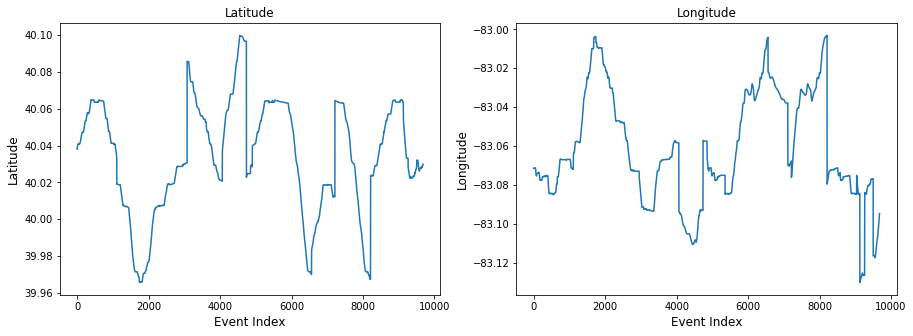

In [48]:
fig,axs = plt.subplots(1,2,figsize=(15,5))
ax1=sample_trips_filtered.latitude.plot(ax=axs[0],title="Latitude")
ax1.set_xlabel('Event Index', fontsize='large')
ax1.set_ylabel('Latitude', fontsize='large')
ax2=sample_trips_filtered.longitude.plot(ax=axs[1],title="Longitude")
ax2.set_xlabel('Event Index', fontsize='large')
ax2.set_ylabel('Longitude', fontsize='large')

Starting to look at the timesteps, first lets change them to a datetime stamp thats a little more intuitive:

In [11]:
sample_trips_filtered['local_dtm']=pd.to_datetime(sample_trips_filtered['local_dtm'],format='%d%b%y:%H:%M:%S')

## Adding in some information to the dataframe based on the latitudude, longitude, timestamps to do analysis on more physically meaningful variables 
The variables being added are the change in position ('DeltaPos (mi)') and time ('DeltaTime (hr)') between two datapoints.  The Speed in miles per hour ('Speed MPH') and acceleration in miles per hour per second ('Accel MPHPS') are also calculated using very basic physics relationships (i.e. speed is change in position per time, instantaneous acceleration is change in speed per time.

The DeltaPos is calculated using the geodesic function from the geopy package in which the default ellipsoid used to model the earth is the standard WGS-84 ellipsoid.  Geopy documentation can be found here: https://geopy.readthedocs.io/en/stable/

In [12]:
sample_trips_filtered['DeltaPos (mi)']=np.nan
sample_trips_filtered.loc[0,'DeltaPos (mi)']=0
sample_trips_filtered.loc[0,'Speed MPH']=0
sample_trips_filtered.loc[0,'Accel MPHPS']=0
sample_trips_filtered.loc[1,'Accel MPHPS']=0
sample_trips_filtered['local_dtm']=pd.to_datetime(sample_trips_filtered['local_dtm'],format='%d%b%y:%H:%M:%S')
#a['DeltaTime']=pd.to_datetime(a['local_dtm'],infer_datetime_format=True)
sample_trips_filtered.loc[0,'DeltaTime (hr)']=0
for i in range(1,len(sample_trips_filtered)):
    sample_trips_filtered.loc[i,'DeltaPos (mi)']=geodesic((sample_trips_filtered.loc[i-1,'latitude'],sample_trips_filtered.loc[i-1,'longitude']),(sample_trips_filtered.loc[i,'latitude'],sample_trips_filtered.loc[i,'longitude'])).miles 
    sample_trips_filtered.loc[i,'DeltaTime (hr)']=pd.Timedelta(sample_trips_filtered.loc[i,'local_dtm']-sample_trips_filtered.loc[i-1,'local_dtm']).seconds/3600.
    sample_trips_filtered.loc[i,'Speed MPH']=sample_trips_filtered.loc[i,'DeltaPos (mi)']/sample_trips_filtered.loc[i,'DeltaTime (hr)']
    if i>1: #need a delta v to calculate instantaneous acceleration otherwise nonsensical information, Not great to check every iteration but sufficient
        sample_trips_filtered.loc[i,'Accel MPHPS']=(sample_trips_filtered.loc[i,'Speed MPH']-sample_trips_filtered.loc[i-1,'Speed MPH'])/(sample_trips_filtered.loc[i,'DeltaTime (hr)']*3600.)
    #

D:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in double_scalars
  if sys.path[0] == '':
D:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in double_scalars
  if sys.path[0] == '':


Text(0, 0.5, 'Instantaneous Acceleration (mph/s)')

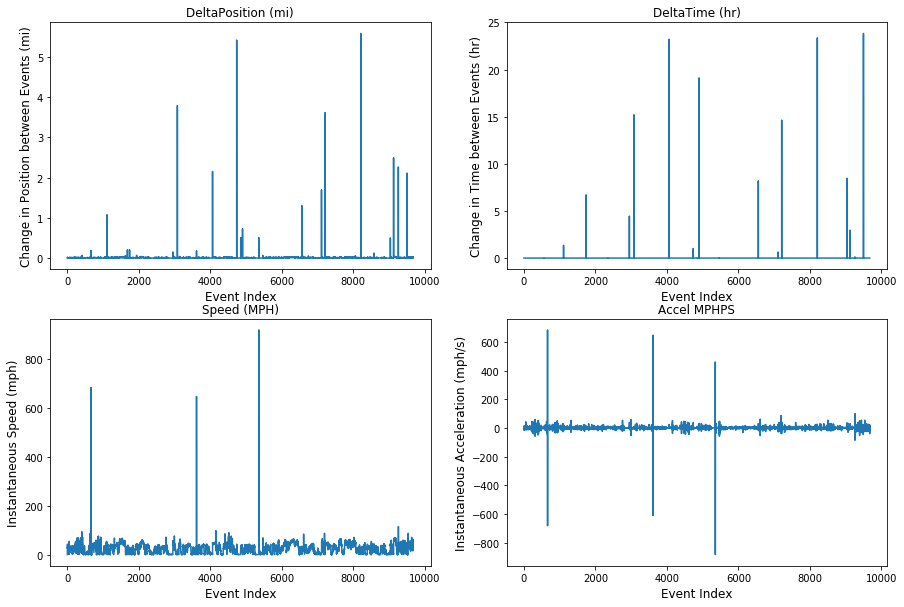

In [51]:
fig,axs = plt.subplots(2,2,figsize=(15,10))
ax1=sample_trips_filtered['DeltaPos (mi)'].plot(ax=axs[0,0],title="DeltaPosition (mi)")
ax1.set_xlabel('Event Index', fontsize='large')
ax1.set_ylabel('Change in Position between Events (mi)', fontsize='large')
ax2=sample_trips_filtered['DeltaTime (hr)'].plot(ax=axs[0,1],title="DeltaTime (hr)")
ax2.set_xlabel('Event Index', fontsize='large')
ax2.set_ylabel('Change in Time between Events (hr)', fontsize='large')
ax3=sample_trips_filtered['Speed MPH'].plot(ax=axs[1,0],title="Speed (MPH)")
ax3.set_xlabel('Event Index', fontsize='large')
ax3.set_ylabel('Instantaneous Speed (mph)', fontsize='large')
ax4=sample_trips_filtered['Accel MPHPS'].plot(ax=axs[1,1],title='Accel MPHPS')
ax4.set_xlabel('Event Index', fontsize='large')
ax4.set_ylabel('Instantaneous Acceleration (mph/s)', fontsize='large')

# Further issues for cleaning consideration
From these plots we can infer 2 issues.  First, from the DeltaPosition and DeltaTime plots there are a large number of drifts.  These drifts account for gps drift between trips. One can count the peaks, in particular in DeltaTime and see there are 15 visible peaks which in addition to the first trip are the 16 total trips accounted for in the dataset.  This can be shown quantitatively by looking at the amount of times the DeltaTime between two points is greater than 36 seconds (0.01hours).  These points should not cause issues in estimations of speed and number of hard acceleration events.  This is implied because they do not show up in the speed and acceleration plots and I can look at trips individually which after further cleaning will be self consistent to themselves.

Secondly, it can see  speed and acceleration plots something odd is going on in at least 3 further points by the points that seem unphysical (i.e. hundreds of mph/s accelerations which are then mirrored or speeds well in excess of 600mph.  These points come from errors in reading for a few seconds.  These points need to be dealt while.

A third issue comes when the DeltaTime between two events is 0, this could easily occur if the recording device has an error in the frequency at which it records, i.e. if the frequency drops below 1Hz and you take two readings within a second.  To deal with the additional points will be dropped. The alternative is averaging the longitude,latitude values but as any single second will be a small change the average would not have much of an effect that isnt averaged out in the acceleration.  It would be more computationally appropriate to check the timestamps first and average the indices that way however as an exercise I feel it is important to show how I came about this solution and the order in which I decided to clean the events.

In [14]:
print(sample_trips_filtered[sample_trips_filtered['DeltaTime (hr)']>0.01].index,'\n Number of time intervals greater than 36seconds (0.01hr):', len(sample_trips_filtered[sample_trips_filtered['DeltaTime (hr)']>0.1].index))

Int64Index([ 563, 1109, 1680, 1741, 2350, 2951, 3078, 4062, 4738, 4851, 4901,
            5467, 6559, 7111, 7213, 8210, 9038, 9128, 9261, 9501],
           dtype='int64') 
 Number of time intervals greater than 36seconds (0.01hr): 15


## Further Cleaning
Here is a list of the times there is 0 change in time from the previous recorded datapoint.  It seems to happen in smallish clusters for the most part just by looking at the indices.  The first point is obviously ok as it is the initial time period and DeltaTime (hr) was initialized to 0 by myself.  This happens 24 additional times

Now that we will filter out the repeat time points and remake the dataframe with the speed/acceleration etc

In [15]:
coincidenceList = sample_trips_filtered[sample_trips_filtered['DeltaTime (hr)']==0.].index
print(coincidenceList[1:])
sample_trips_filtered2=sample_trips_filtered.drop(sample_trips_filtered.index[coincidenceList[1:]])
sample_trips_filtered2 = sample_trips_filtered2.reset_index(drop=True)

sample_trips_filtered2['DeltaPos (mi)']=np.nan
sample_trips_filtered2.loc[0,'DeltaPos (mi)']=0
sample_trips_filtered2.loc[0,'Speed MPH']=0
sample_trips_filtered2.loc[0,'Accel MPHPS']=0
sample_trips_filtered2.loc[1,'Accel MPHPS']=0
#sample_trips_filtered2['local_dtm']=pd.to_datetime(sample_trips_filtered2['local_dtm'],format='%d%b%y:%H:%M:%S')
sample_trips_filtered2.loc[0,'DeltaTime (hr)']=0
for i in range(1,len(sample_trips_filtered2)):
    sample_trips_filtered2.loc[i,'DeltaPos (mi)']=geodesic((sample_trips_filtered2.loc[i-1,'latitude'],sample_trips_filtered2.loc[i-1,'longitude']),(sample_trips_filtered2.loc[i,'latitude'],sample_trips_filtered2.loc[i,'longitude'])).miles 
    sample_trips_filtered2.loc[i,'DeltaTime (hr)']=pd.Timedelta(sample_trips_filtered2.loc[i,'local_dtm']-sample_trips_filtered2.loc[i-1,'local_dtm']).seconds/3600.
    sample_trips_filtered2.loc[i,'Speed MPH']=sample_trips_filtered2.loc[i,'DeltaPos (mi)']/sample_trips_filtered2.loc[i,'DeltaTime (hr)']
    if i>1: #need a delta v to calculate instantaneous acceleration otherwise nonsensical information, Not great to check every iteration but sufficient
        sample_trips_filtered2.loc[i,'Accel MPHPS']=(sample_trips_filtered2.loc[i,'Speed MPH']-sample_trips_filtered2.loc[i-1,'Speed MPH'])/(sample_trips_filtered2.loc[i,'DeltaTime (hr)']*3600.)
    #

Int64Index([ 712,  722,  726,  744,  926, 4148, 4153, 4274, 4341, 4547, 4566,
            4720, 4726, 4731, 6747, 6748, 6749, 6750, 7207, 8720, 8722, 8790,
            8792, 9003],
           dtype='int64')


Let's look around these points in speed, the acceleration curve and mirroring will be taken care of if the speed/position issues are removed.  These are caused by GPS Jumps to a new base point.  Just removing these events would not take care of the issue as the base point has drifted and recalculating the speeds/accelerations after the removal would show the same issues, perhaps even exaggerated more depending on the jumps.
One potential solution is to interpolate the speed at the odd indices manually by the speed on either side.  We 

In [16]:
print(len(sample_trips_filtered2[sample_trips_filtered2['Speed MPH']>100.].index))
for i in sample_trips_filtered2[sample_trips_filtered2['Speed MPH']>100.].index:
    print(sample_trips_filtered2.loc[i-1:i+1])

4
     trip_nb           local_dtm   latitude  longitude  DeltaPos (mi)  \
660        1 2017-05-19 07:47:41  40.064354 -83.079346       0.000000   
661        1 2017-05-19 07:47:42  40.064281 -83.075768       0.189742   
662        1 2017-05-19 07:47:43  40.064281 -83.075768       0.000000   

      Speed MPH  Accel MPHPS  DeltaTime (hr)  
660    0.000000     0.000000        0.000278  
661  683.070781   683.070781        0.000278  
662    0.000000  -683.070781        0.000278  
      trip_nb           local_dtm   latitude  longitude  DeltaPos (mi)  \
3608        5 2017-05-20 12:27:19  40.052776 -83.067070       0.000000   
3609        5 2017-05-20 12:27:20  40.050175 -83.066933       0.179601   
3610        5 2017-05-20 12:27:21  40.050034 -83.066940       0.009735   

       Speed MPH  Accel MPHPS  DeltaTime (hr)  
3608    0.000000     0.000000        0.000278  
3609  646.564407   646.564407        0.000278  
3610   35.046997  -611.517410        0.000278  
      trip_nb           loca

In [17]:
print(len(sample_trips_filtered2[sample_trips_filtered2['DeltaPos (mi)']>1.].index))
#for i in sample_trips_filtered2[sample_trips_filtered2['DeltaPos (mi)']>1.].index:
#    print(sample_trips_filtered2.loc[i-1:i+1]);

11


In [18]:
sample_trips_filtered2[(sample_trips_filtered2['Speed MPH']>100.) & (np.abs(sample_trips_filtered2['Accel MPHPS'])>30)].index

Int64Index([661, 3609, 5341, 9239], dtype='int64')

In [19]:
sample_trips_filtered2[(np.abs(sample_trips_filtered2['Accel MPHPS'])>40)].index

Int64Index([  52,  227,  274,  275,  301,  302,  311,  312,  315,  393,  394,
             404,  405,  635,  639,  661,  662,  721,  722,  724,  929, 1311,
            2754, 2989, 2990, 3609, 3610, 4143, 4144, 4149, 4400, 4463, 4510,
            4511, 4606, 5341, 5342, 5455, 5456, 5460, 5461, 6597, 6598, 7177,
            7195, 8488, 9239, 9240, 9368, 9369, 9420, 9468, 9513, 9652],
           dtype='int64')

Find the points that we want to adapt.  In this dataset they coincide with excessive speed as well as excessive acceleration.  The maximal acceleration by the cars is around 20-25mphps so a large buffer is given to this and the additional speed requirement is required as the acceleration at such a speed would be lower.  Go through, interpolate the speed at those points and recalculate the accleration for the entire dataframe

In [20]:
changeList = sample_trips_filtered2[(sample_trips_filtered2['Speed MPH']>100.) & (np.abs(sample_trips_filtered2['Accel MPHPS'])>30)].index
print('Indices to be changed: ',changeList)
sample_trips_filtered3=sample_trips_filtered2.copy()
for index in changeList:
    sample_trips_filtered3.loc[index,'Speed MPH']=(sample_trips_filtered3.loc[index-1,'Speed MPH']+sample_trips_filtered3.loc[index+1,'Speed MPH'])/2
for i in range(2,len(sample_trips_filtered3)):
    sample_trips_filtered3.loc[i,'Accel MPHPS']=(sample_trips_filtered3.loc[i,'Speed MPH']-sample_trips_filtered3.loc[i-1,'Speed MPH'])/(sample_trips_filtered3.loc[i,'DeltaTime (hr)']*3600.)
 

Indices to be changed:  Int64Index([661, 3609, 5341, 9239], dtype='int64')


Text(0, 0.5, 'Instantaneous Acceleration (mph/s)')

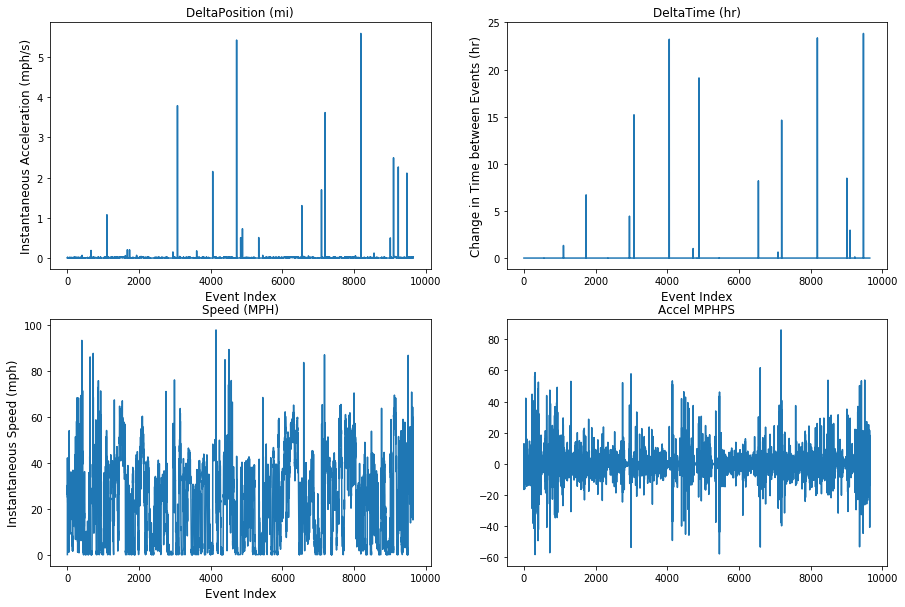

In [52]:
fig,axs = plt.subplots(2,2,figsize=(15,10))
ax1=sample_trips_filtered3['DeltaPos (mi)'].plot(ax=axs[0,0],title="DeltaPosition (mi)")
ax1.set_xlabel('Event Index', fontsize='large')
ax1.set_ylabel('Change in Position between Events (mi)', fontsize='large')
ax2=sample_trips_filtered3['DeltaTime (hr)'].plot(ax=axs[0,1],title="DeltaTime (hr)")
ax2.set_xlabel('Event Index', fontsize='large')
ax2.set_ylabel('Change in Time between Events (hr)', fontsize='large')
ax3=sample_trips_filtered3['Speed MPH'].plot(ax=axs[1,0],title="Speed (MPH)")
ax3.set_xlabel('Event Index', fontsize='large')
ax3.set_ylabel('Instantaneous Speed (mph)', fontsize='large')
ax4=sample_trips_filtered3['Accel MPHPS'].plot(ax=axs[1,1],title='Accel MPHPS')
ax1.set_xlabel('Event Index', fontsize='large')
ax1.set_ylabel('Instantaneous Acceleration (mph/s)', fontsize='large')

Here are the results after very basic data cleaning has been applied to remove unphysical events.  For the most part this puts the speed data within both legal possible realms.  Before I start classifying I want to apply a mild rolling average to the speeds and recalculate the accelerations to help remove some of the noise while keeping the general structure.

In [22]:
sample_trips_filtered3['SpeedAvg']=sample_trips_filtered3.loc[:,'Speed MPH'].rolling(window=3).mean()
sample_trips_filtered3['AccelAvg3']=sample_trips_filtered3.loc[:,'Accel MPHPS'].rolling(window=3).mean()

for i in range(2,len(sample_trips_filtered3)):
    sample_trips_filtered3.loc[i,'AccelAvg']=(sample_trips_filtered3.loc[i,'SpeedAvg']-sample_trips_filtered3.loc[i-1,'SpeedAvg'])/(sample_trips_filtered3.loc[i,'DeltaTime (hr)']*3600.)

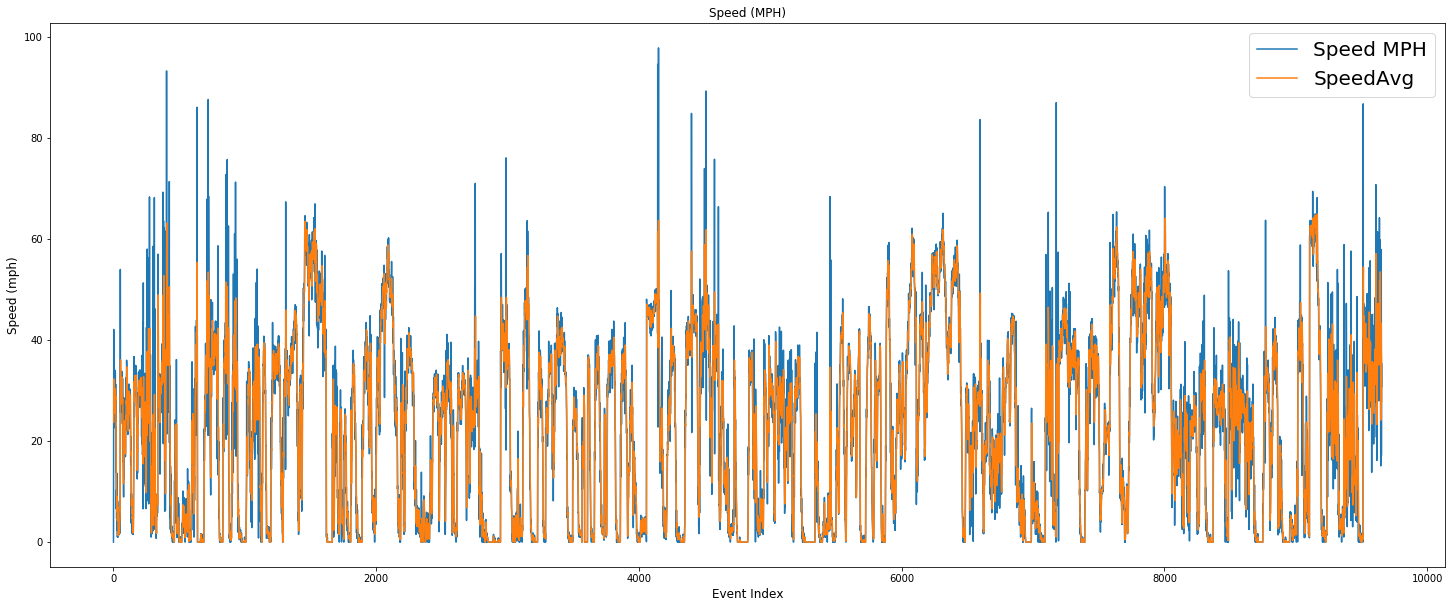

In [57]:
fig,axs = plt.subplots(1,1,figsize=(25,10))
sample_trips_filtered3['Speed MPH'].plot(title="Speed (MPH)")
ax=sample_trips_filtered3['SpeedAvg'].plot(title="Speed (MPH)")
ax.set_xlabel('Event Index', fontsize='large')
ax.set_ylabel('Speed (mph)', fontsize='large')
plt.legend(loc='best',prop={'size': 20})

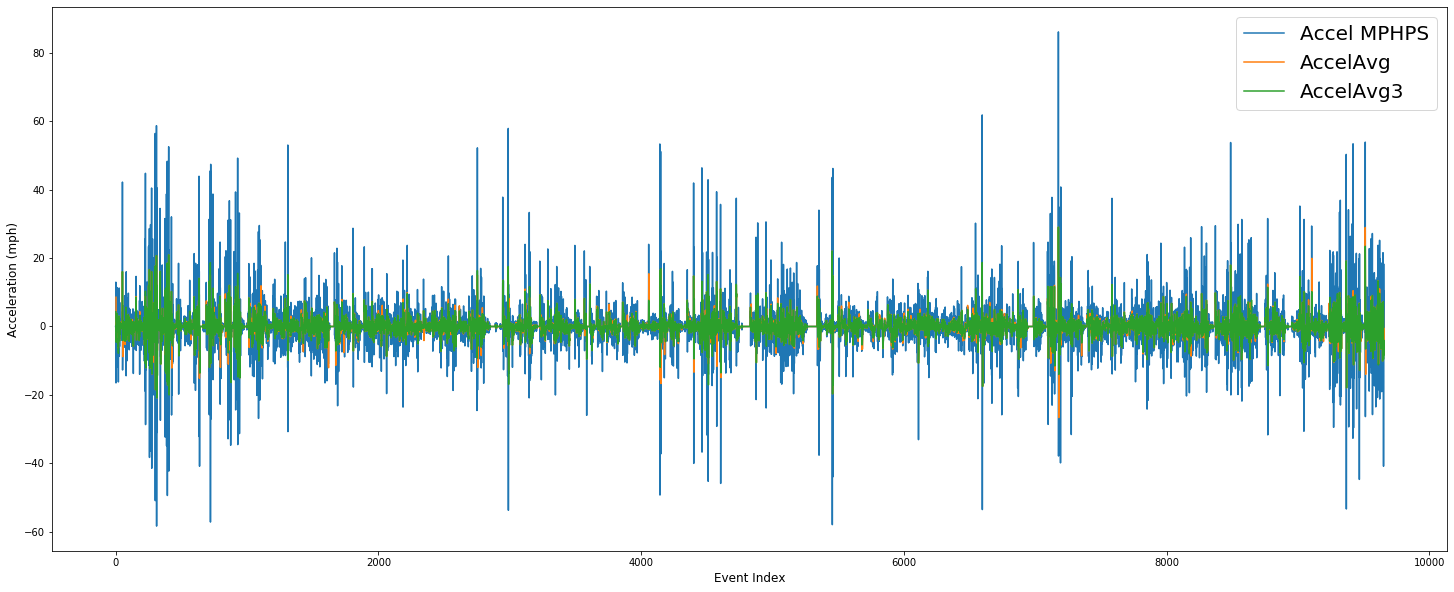

In [59]:
fig,axs = plt.subplots(1,1,figsize=(25,10))
sample_trips_filtered3['Accel MPHPS'].plot()
sample_trips_filtered3['AccelAvg'].plot()
ax=sample_trips_filtered3['AccelAvg3'].plot()
ax.set_xlabel('Event Index', fontsize='large')
ax.set_ylabel('Acceleration (mph)', fontsize='large')
plt.legend(loc='best',prop={'size': 20})

# Trip by Trip Investigations

In [25]:
#Loading each individual trip into its own object to further examine each trip on an individual basis
# 
trip_dict={}
for trip_id in range(1,17):
    trip_dict[str(trip_id)]=sample_trips_filtered3[sample_trips_filtered3.trip_nb == trip_id]
    #Also need to reset DeltaTime between trips
    trip_dict[str(trip_id)].loc[(trip_dict[str(trip_id)].head(1).index[0],'DeltaTime (hr)')]=0.

D:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


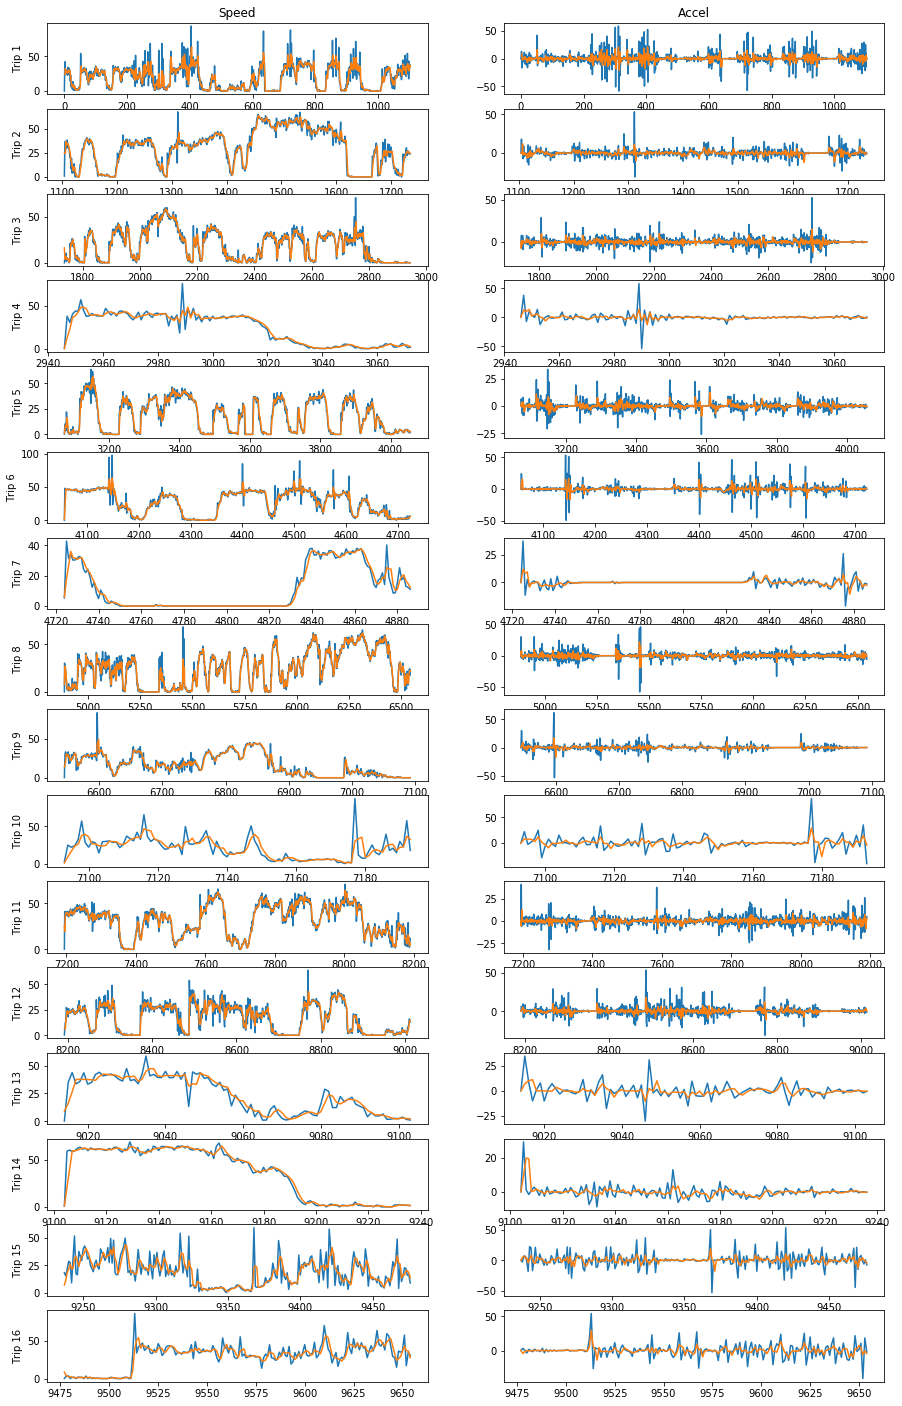

In [26]:
fig,axs = plt.subplots(16,2,figsize=(15,25))
for i in range(1,17):
    axs[0,0].set_title('Speed')
    axs[0,1].set_title('Accel')
    axs[i-1,0].set_ylabel('Trip '+str(i))
    trip_dict[str(i)]['Speed MPH'].plot(ax=axs[i-1,0])
    trip_dict[str(i)]['SpeedAvg'].plot(ax=axs[i-1,0])
    trip_dict[str(i)]['Accel MPHPS'].plot(ax=axs[i-1,1])
    trip_dict[str(i)]['AccelAvg'].plot(ax=axs[i-1,1])

# Setting a Threshold for hard events (braking and acceleration) baed on the data.
## Hard Braking Events
Having no a priori intuition about numbers to use for hard braking and acceleration events I first looked up some baseline numbers
Some definitions need to be worked out i.e. what am I considering a hard event.  After some brief cursory research I've found a negative acceleration at around 7mph/s and up to 15mph/s to be standard for 18 wheelers (https://www.michiganautolaw.com/blog/2017/11/05/hard-braking/).  If we use this minimal value as a hard braking cutoff it will be the number of times the acceleration is calculated at <-7mph/s
## Hard Acceleration Events
For hard accelerations I'm going to set my threshold based on 0-60 times for typical cars, let's take a mid 2000s Corolla for example the 0-60 time is around 8 seconds (https://www.zeroto60times.com/vehicle-make/toyota-0-60-mph-times/).  If we allow for some buffer room above this i.e. around 10 seconds instead of 8 for a hard cutoff on hard accelerations it would be the number of events where the acceleration is above 6mph/s.  I would certainly consider the maximum acceleration for a vehicle in proper working order to be more than a hard acceleration event. However, I recognize that this is very depedent upon the vehicle i.e., a loaded down smart car is most likely incapable of a hard acceleration which by itself could lead to unsafety as hard accelerations can be used to avoid incidents.  Using the averaged value in a window of 3 seconds should be sufficient without smearing out the largest acceleration and braking events.
## Idle Time
Time spent below while moving with an average (window=3) speed less than 1mph, allows moderate drift while stopped

Now, lets compare how these reference hard acceleration numbers compare to the average acceleration and average braking  values

0.06975110539512015
2.710460667334003


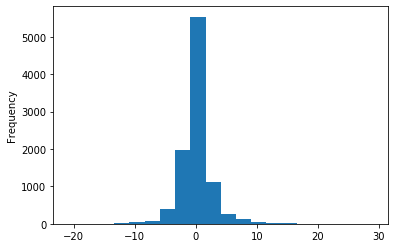

In [27]:
sample_trips_filtered3['AccelAvg3'].plot.hist(bins=20)
print(sample_trips_filtered3['AccelAvg3'].mean())
print(sample_trips_filtered3['AccelAvg3'].std())

In [28]:
print("Average Positive Acceleration: ",sample_trips_filtered3[sample_trips_filtered3['AccelAvg3']>0.]['AccelAvg3'].mean())
print("Standard Deviation: ",sample_trips_filtered3[sample_trips_filtered3['AccelAvg3']>0.]['AccelAvg3'].std())

Average Positive Acceleration:  1.71086711388756
Standard Deviation:  2.381725409735693


In [29]:
print("Average Negative Acceleration: ",sample_trips_filtered3[sample_trips_filtered3['AccelAvg3']<0.]['AccelAvg3'].mean())
print("Standard Deviation: ",sample_trips_filtered3[sample_trips_filtered3['AccelAvg3']<0.]['AccelAvg3'].std())

Average Negative Acceleration:  -1.6224397530057804
Standard Deviation:  1.9791184661984416


So, the average acceleration (using the window=3 rolilng average) is 1.71mph/s compared to the hard acceleration estimation I found to be around 6-7.5 mph/s.  The average braking acceleration (-1.62mph/s) compared to the -7mph/s.  For simplicity going forward I will use assume that the distribution of accelerations is normal enough that I can assume a half normal distribution and use the mean+2standard deviations for acceleration threshold and mean-2standard deviations for the braking acceleration threshold.

## Thresholds - Acceleration: 6.47mph/s, Braking: -5.58mph/s

Lets create a few helper functions to return the amount of hard acceleration events, hard braking events, total idle time, and total distance traveled.  For hard braking and acceleration I am choosing to use the rolling average value and count peaks above my above determined threshold to get individual events and not just the time within those events

In [30]:
def GetHardEvents(df,threshold,AccelBrake):
    sign = 1
    if AccelBrake == "Accel":
        sign =1
    elif AccelBrake == "Brake":
        sign =-1
    peaks=0
    for i in range(df.head(1).index[0]+1,df.tail(1).index[0]-1):
        if sign*df.AccelAvg3[i]>sign*df.AccelAvg3[i-1]:
            if sign*df.AccelAvg3[i]>sign*df.AccelAvg3[i+1]:
                if sign*df.AccelAvg3[i]>threshold:
                    #print(i)
                    peaks+=1
    return peaks

def GetIdleTotalTime(df):
    IdleTime, TotalTime=0.,0.
    try: #handles exception in case of 0 idle time as defined below
        IdleTime = df['DeltaTime (hr)'][(df['SpeedAvg'])<1.].cumsum().iloc[-1]
    except IndexError:
        print("No Idle Time for this Trip")
    TotalTime = df['DeltaTime (hr)'].cumsum().iloc[-1]
    return IdleTime*60, TotalTime*60

def GetIntegralDistance(df):
    distance=0
    distance= df['DeltaPos (mi)'].cumsum()
    return distance.iloc[-1]
    

# Summary of Trips

In [60]:
for i in range(1,17):
    print("Trip: ", str(i))
    print('\t Hard Accel Events: %i '%(GetHardEvents(trip_dict[str(i)],6.47,"Accel")))
    print('\t Hard Brake Events: %i '%(GetHardEvents(trip_dict[str(i)],5.58,"Brake")))
    print('\t Idle Time: %.2f min, \t Total Time: %.2f min'%(GetIdleTotalTime(trip_dict[str(i)])))
    print('\t Distance Traveled: %.2f mi \n'%(GetIntegralDistance(trip_dict[str(i)])))

Trip:  1
	 Hard Accel Events: 47 
	 Hard Brake Events: 40 
	 Idle Time: 3.05 min, 	 Total Time: 22.25 min
	 Distance Traveled: 6.83 mi 

Trip:  2
	 Hard Accel Events: 7 
	 Hard Brake Events: 5 
	 Idle Time: 1.15 min, 	 Total Time: 13.03 min
	 Distance Traveled: 7.29 mi 

Trip:  3
	 Hard Accel Events: 10 
	 Hard Brake Events: 11 
	 Idle Time: 3.45 min, 	 Total Time: 24.45 min
	 Distance Traveled: 7.77 mi 

Trip:  4
	 Hard Accel Events: 3 
	 Hard Brake Events: 1 
	 Idle Time: 0.23 min, 	 Total Time: 2.33 min
	 Distance Traveled: 1.06 mi 

Trip:  5
	 Hard Accel Events: 10 
	 Hard Brake Events: 5 
	 Idle Time: 3.07 min, 	 Total Time: 18.70 min
	 Distance Traveled: 9.75 mi 

Trip:  6
	 Hard Accel Events: 18 
	 Hard Brake Events: 10 
	 Idle Time: 0.90 min, 	 Total Time: 12.60 min
	 Distance Traveled: 7.83 mi 

Trip:  7
	 Hard Accel Events: 3 
	 Hard Brake Events: 1 
	 Idle Time: 1.48 min, 	 Total Time: 4.03 min
	 Distance Traveled: 6.55 mi 

Trip:  8
	 Hard Accel Events: 11 
	 Hard Brake Eve